C:\Users\roybi\Desktop\bert_network\venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


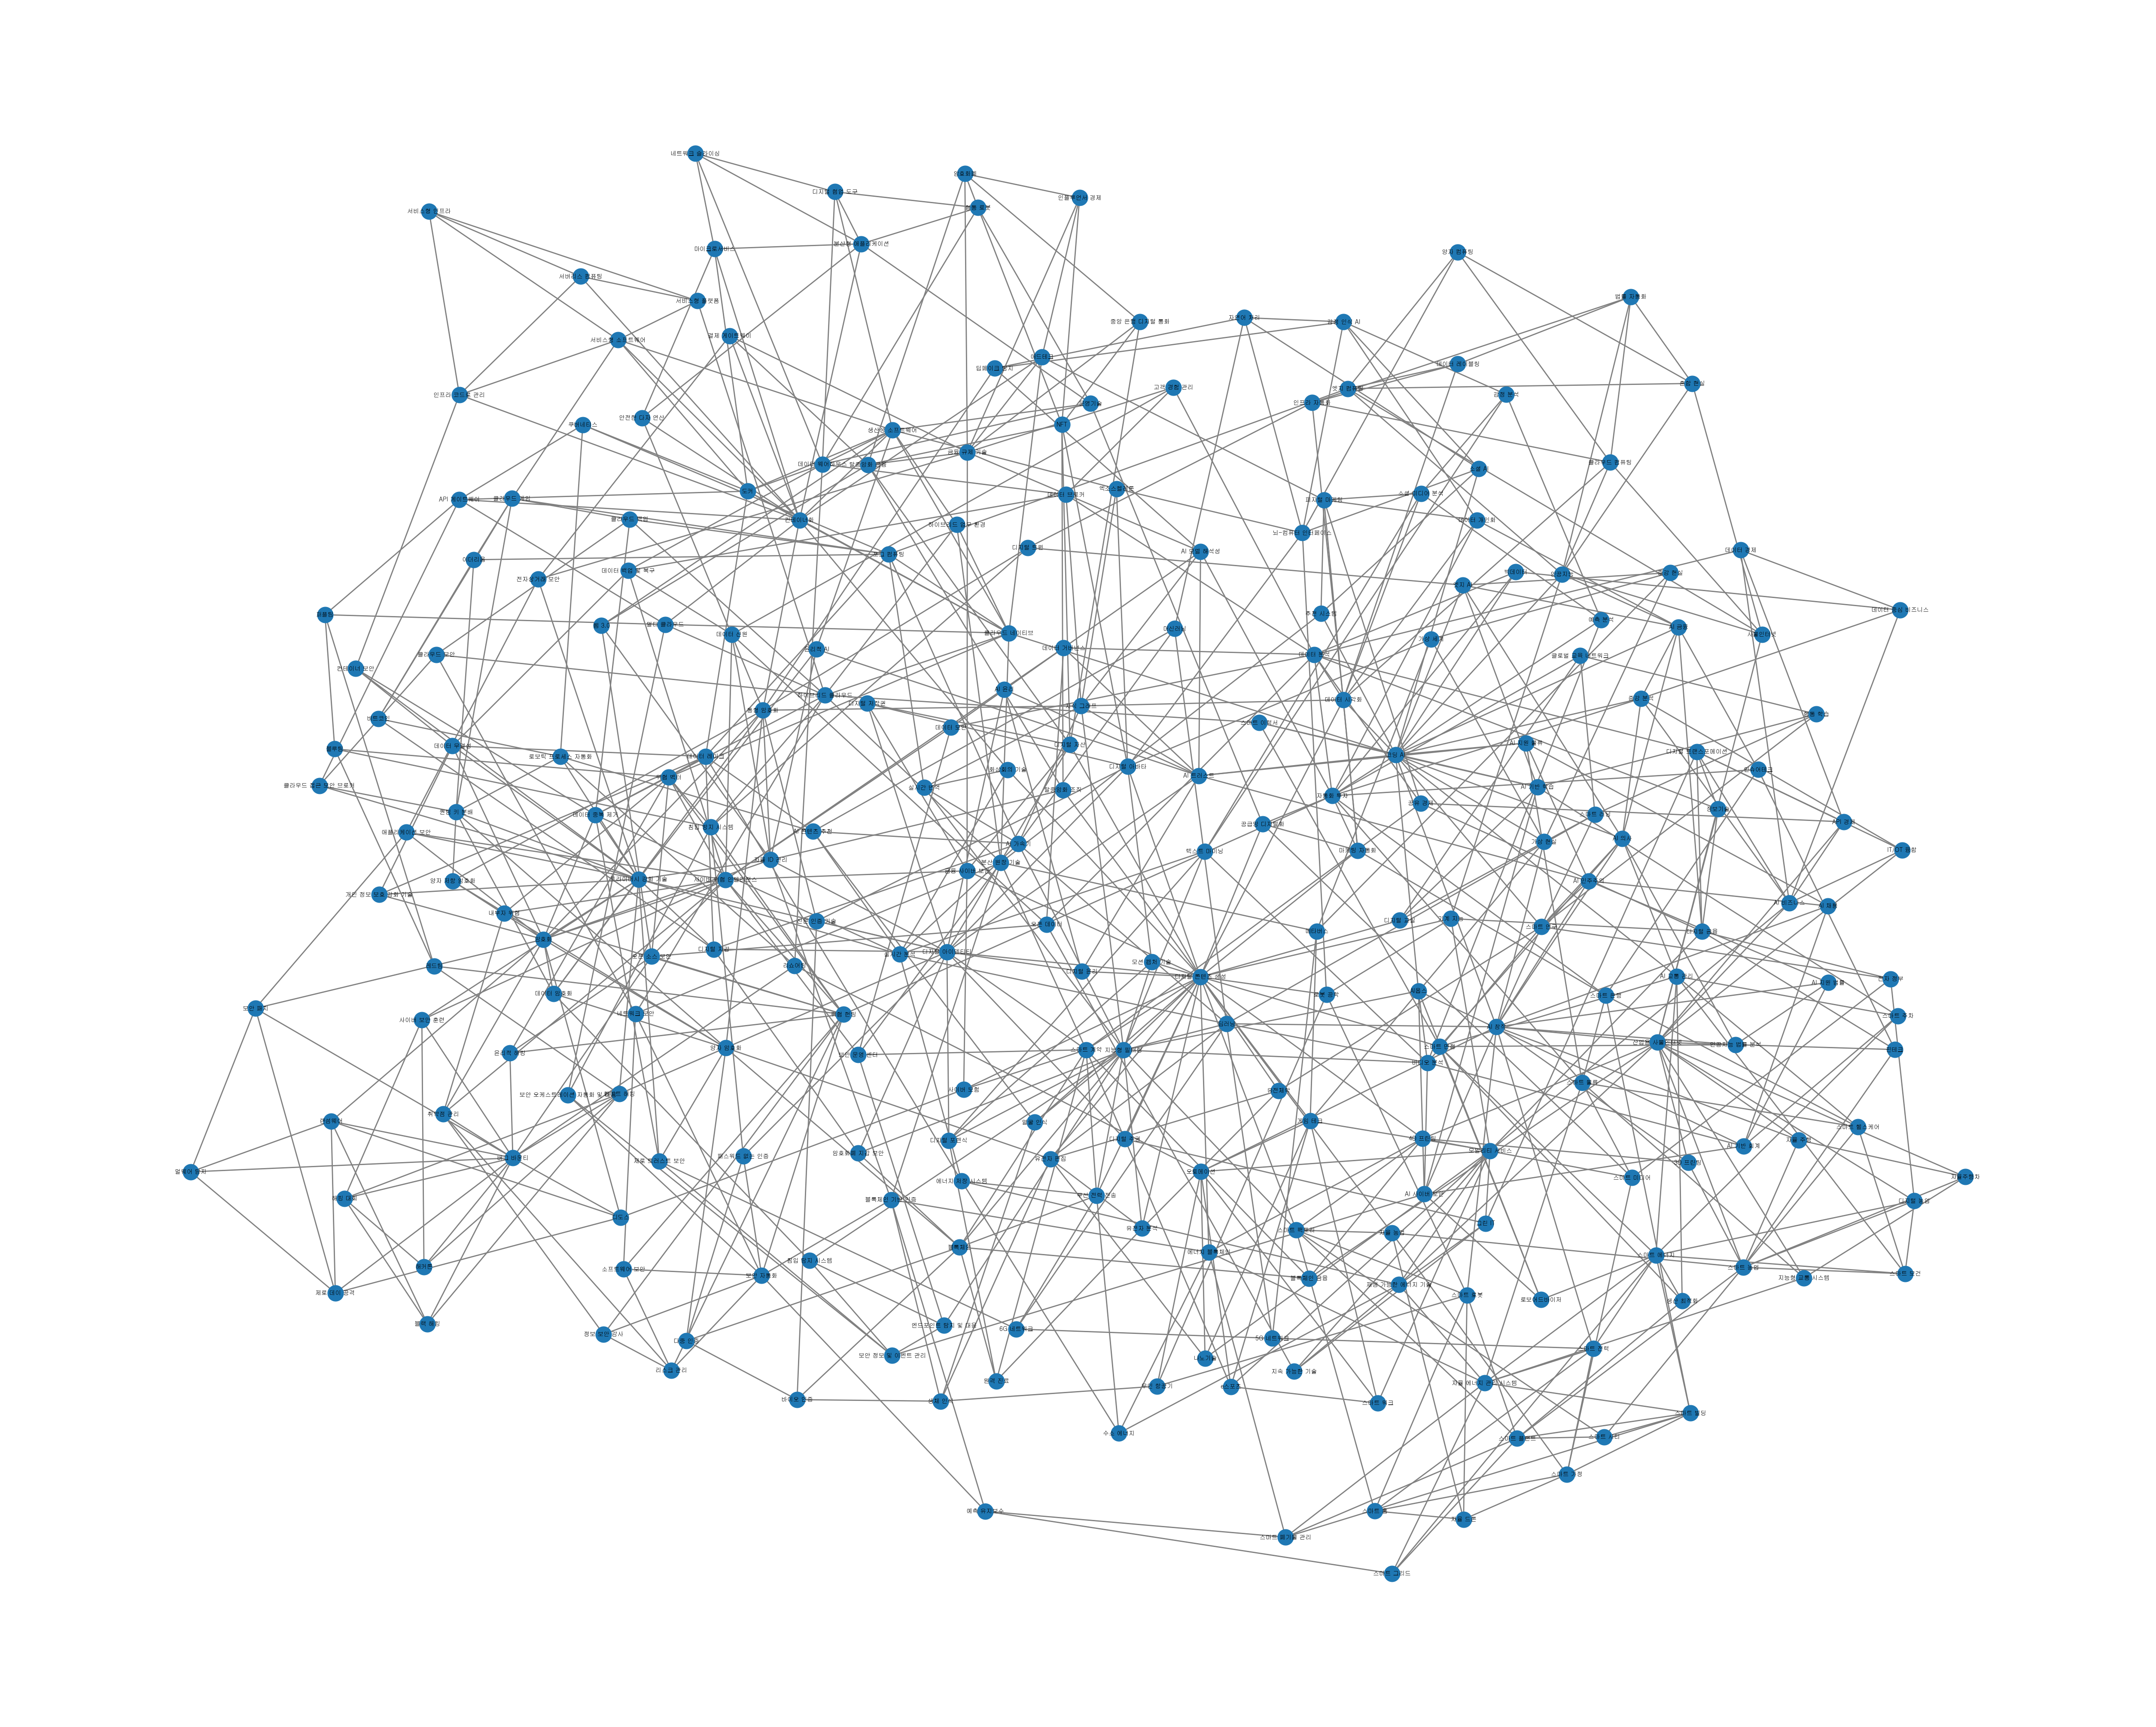

네트워크 데이터가 'network_data.json' 파일로 저장되었습니다.


In [ ]:
import pandas as pd
import torch
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import json
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm  # 한글 폰트 설정을 위해 필요
from matplotlib import rc

# 0. 한글 폰트 설정
font_path = "C:/Windows/Fonts/gulim.ttc"  # Windows 경로
fontprop = fm.FontProperties(fname=font_path)
rc('font', family=fontprop.get_name())

# 1. 데이터 로드
def load_data(file_path):
    it_keywords = pd.read_csv(file_path)
    return it_keywords

# 2. KoBERT 모델 및 토크나이저 설정
def get_kobert_model(vocab_file_path):
    tokenizer = KoBERTTokenizer(vocab_file=vocab_file_path)
    model = BertModel.from_pretrained('skt/kobert-base-v1')
    return model, tokenizer

# 3. 텍스트 임베딩
def embed_meanings(model, tokenizer, terms):
    meanings = terms['mean'].tolist()
    
    embeddings = []
    for meaning in meanings:
        inputs = tokenizer(meaning, return_tensors='pt', padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
        embeddings.append(cls_embedding)
    
    return embeddings

# 4. 코사인 유사도 계산
def calculate_cosine_similarity(embeddings):
    similarity_matrix = cosine_similarity(embeddings)
    return similarity_matrix

# 5. 네트워크 생성 (자가루프 제거)
def create_network(terms, similarity_matrix, threshold=0.90, max_edges=5):
    G = nx.Graph()

    # 노드 추가 (term_ko 사용)
    for idx, term_ko in enumerate(terms['term_ko']):
        G.add_node(term_ko)

    # 엣지 추가 (유사도가 임계값 이상일 때, 자기 자신을 가리키는 경우 제외)
    num_terms = len(terms)
    for i in range(num_terms):
        # 각 노드의 다른 노드들과의 유사도를 저장한 후 정령
        similarities = [(j, similarity_matrix[i, j]) for j in range(num_terms) if similarity_matrix[i, j] >= threshold]
        similarities = sorted(similarities, key=lambda x: x[1], reverse=True)[:max_edges]
        for j, sim in similarities:
            if i != j and not G.has_edge(terms['term_ko'][i], terms['term_ko'][j]):  # i != j로 자가루프 제거 및 중복 엣지 방지
                G.add_edge(terms['term_ko'][i], terms['term_ko'][j], weight=sim)

    # 자가루프 제거
    G.remove_edges_from(nx.selfloop_edges(G))

    return G

# 6. 네트워크를 JSON 파일로 저장 (연결된 노드의 label도 저장)
def save_network_as_json(G, terms, file_path='network_data.json'):
    pos = nx.kamada_kawai_layout(G)  # 노드 배치를 설정
    
    # float32를 float으로 변환하는 부분 추가
    nodes = []
    for idx, term_ko in enumerate(terms['term_ko']):
        # 현재 노드에 연결된 노드들 (term_ko 기준)
        connected_nodes = list(G.neighbors(term_ko))
        # 연결된 노드들의 label (term_ko) 목록
        connected_labels = [connected for connected in connected_nodes]
        
        node_data = {
            "id": idx,
            "label": term_ko,
            "label_full": terms['term'].iloc[idx],  # term 전체 저장
            "label_en": terms['term_en'].iloc[idx],  # 영어 term 저장
            "label_ko": terms['term_ko'].iloc[idx],  # 한국어 term 저장
            "connected_labels": connected_labels,  # 연결된 노드들의 label
            "x": float(pos[term_ko][0]),
            "y": float(pos[term_ko][1])
        }
        nodes.append(node_data)
    
    edges = [{'from': u, 'to': v, 'weight': float(G[u][v]['weight'])} for u, v in G.edges()]

    # 노드 및 엣지 데이터를 포함하는 JSON 파일 저장
    data = {
        'nodes': nodes,
        'edges': edges
    }

    # JSON 파일로 저장
    with open(file_path, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)

# 7. 네트워크 시각화
def plot_network(G):
    pos = nx.kamada_kawai_layout(G)  # 노드 배치를 kamada_kawai_layout으로 설정
    plt.figure(figsize=(50, 40))
    
    # 엣지의 색상을 회색으로 고정
    edge_colors = 'gray'

    # 네트워크 그래프 시각화
    nx.draw(G, pos, with_labels=True, node_size=700, font_size=10, font_weight='bold', 
            edge_color=edge_colors, width=2, font_family=fontprop.get_name())
    
    plt.show()

# 8. 실행 (수정된 부분을 포함)
if __name__ == "__main__":
    # 데이터 로드
    it_keywords = load_data('IT_keywords.csv')

    # KoBERT 모델과 토크나이저 설정
    vocab_file_path = 'spiece.model'
    model, tokenizer = get_kobert_model(vocab_file_path)

    # mean 텍스트를 임베딩
    embeddings = embed_meanings(model, tokenizer, it_keywords)

    # 코사인 유사도 계산
    similarity_matrix = calculate_cosine_similarity(embeddings)

    # 네트워크 생성
    threshold = 0.80
    G = create_network(it_keywords, similarity_matrix, threshold=threshold, max_edges=5)

    # 네트워크 시각화
    plot_network(G)

    # 네트워크 데이터를 JSON으로 저장 (terms 데이터를 추가로 전달)
    save_network_as_json(G, it_keywords, file_path='network_data.json2')

    print("네트워크 데이터가 'network_data.json' 파일로 저장되었습니다.")
